In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import random

# Set up the game.

Define the rank and suit of a card.

In [2]:
import enum

ranks = {
    "two" : 2,
    "three" : 3,
    "four" : 4,
    "five" : 5,
    "six" : 6,
    "seven" : 7,
    "eight" : 8,
    "nine" : 9,
    "ten" : 10,
    "jack" : 10,
    "queen" : 10,
    "king" : 10,
    "ace" : (1, 11)
}
    
class Suit(enum.Enum):
    spades = "spades"
    clubs = "clubs"
    diamonds = "diamonds"
    hearts = "hearts"

Define a card and a deck.

Implement shuffle, peek, & deal functions for the deck.

In [3]:
class Card:
    def __init__(self, suit, rank, value):
        self.suit = suit
        self.rank = rank
        self.value = value
        
    def __str__(self):
        return self.rank + " of " + self.suit.value

class Deck:
    def __init__(self, num=1):
        self.cards = []
        for i in range(num):
            for suit in Suit:
                for rank, value in ranks.items():
                    self.cards.append(Card(suit, rank, value))
                
    def shuffle(self):
        random.shuffle(self.cards)
        
    def deal(self):
        return self.cards.pop(0)
    
    def peek(self):
        if len(self.cards) > 0:
            return self.cards[0]
        
    def add_to_bottom(self, card):
        self.cards.append(card)
        
    def __str__(self):
        result = ""
        for card in self.cards:
            result += str(card) + "\n"
        return result
    
    def __len__(self):
        return len(self.cards)

# Set up Blackjack

### Define logic for evaluating the value of the dealer's hand.

Trickiest part is defining the logic for Aces.

_Dealer Logic will not change much! They must follow a set, predictable course of action._

In [4]:
# This follows the same, official rules every time.
# Still need to figure out what happens if there are multiple Aces.
def dealer_eval(player_hand):
    num_ace = 0
    use_one = 0
    for card in player_hand:
        if card.rank == "ace":
            num_ace += 1
            use_one += card.value[0] # use 1 for Ace
        else:
            use_one += card.value
    
    if num_ace > 0:
        # See if using 11 instead of 1 for the Aces gets the 
        # dealer's hand value closer to the [17, 21] range
        
        # The dealer will follow Hard 17 rules.
        # This means the dealer will not hit again if
        # the Ace yields a 17. 
        
        # This also means that Aces initially declared as 11's can
        # be changed to 1's as new cards come.
        
        ace_counter = 0
        while ace_counter < num_ace:
            # Only add by 10 b/c 1 is already added before
            use_eleven = use_one + 10 
            
            if use_eleven > 21:
                return use_one
            elif use_eleven >= 17 and use_eleven <= 21:
                return use_eleven
            else:
                # The case where even using Ace as eleven is less than 17.
                use_one = use_eleven
            
            ace_counter += 1
        
        return use_one
    else:
        return use_one

### Define logic for evaluating the value of the player's hand.

Trickiest part is defining the logic for Aces.

_This logic is subject to change._

In [5]:
def player_eval(player_hand):
    num_ace = 0
    # use_one means that every ace that in the hand is counted as one.
    use_one = 0
    for card in player_hand:
        if card.rank == "ace":
            num_ace += 1
            use_one += card.value[0] # use 1 for Ace
        else:
            use_one += card.value
    
    if num_ace > 0:
        # Define player policy for Aces:
        # Make Aces 11 if they get you to the range [18,21]
        # Otherwise, use one.
        
        ace_counter = 0
        while ace_counter < num_ace:
            # Only add by 10 b/c 1 is already added before
            use_eleven = use_one + 10 
            
            if use_eleven > 21:
                return use_one
            elif use_eleven >= 18 and use_eleven <= 21:
                return use_eleven
            else:
                # This allows for some Aces to be 11s, and others to be 1.
                use_one = use_eleven
            
            ace_counter += 1
        
        return use_one
    else:
        return use_one

### Define logic for the dealer's turn.

This will not change much since the dealer has to follow a defined protocol when making their moves.

In [6]:
def dealer_turn(dealer_hand, deck):
    # Calculate dealer hand's value.
    dealer_value = dealer_eval(dealer_hand)

    # Define dealer policy (is fixed to official rules)

    # The dealer keeps hitting until their total is 17 or more
    while dealer_value < 17:
        # hit
        dealer_hand.append(deck.deal())
        dealer_value = dealer_eval(dealer_hand)

    return dealer_value, dealer_hand, deck

### Main Blackjack play_game() function.

Can use higher-order functions functionality to pick which player policy to use.

In [50]:
def play_game(player_policy, num_decks = 2, start_cash = 1000, num_rounds = 100):
    # Our Blackjack deck will be made of 2 normal decks by default.
    bj_deck = Deck(num_decks)

    # Shuffle before beginning. Only shuffle once before the start of each game.
    bj_deck.shuffle()
    
    # Keeps track of rewards/punishments. Also allows game to end before num_rounds.
    player_cash = start_cash
    
    rounds_played = 0
    
    while rounds_played < num_rounds and player_cash > 0:
        # Assume player bets 100 each round.
        # Gains 100 for winning round.
        # Loses 100 for losing round.
        # Nothing happens if tie. (Needs to change when actually training, so that agent tries to win more than tie.)
        
        player_hand = [bj_deck.deal(), bj_deck.deal()]
        dealer_hand = [bj_deck.deal(), bj_deck.deal()]
        
        # The current policy does not care about dealer's upcard.
        #dealer_upcard = dealer_hand[0]
        
        ## Begin player turn phase.
        
        player_value, player_hand, bj_deck = player_policy(player_hand, bj_deck)
            
        ## Player turn phase over.
        
        #--------------------------------------------------------#
        
        ## Begin automated phase of the Dealer's Play and
        ## determining the winner of the round.
        
        if player_value > 21: # above 21, player loses automatically.
            player_cash -= 100
        elif player_value == 21: # blackjack! Player wins automatically.
            player_cash += 100
        else:
            ## Begin dealer turn phase.
            
            dealer_value, dealer_hand, bj_deck = dealer_turn(dealer_hand, bj_deck)
                
            ## End of dealer turn phase
            
            #------------------------------------------------------------#
            
            ## Final Compare
            
            if dealer_value > 21: # dealer above 21, player wins automatically
                player_cash += 100
            elif dealer_value == 21: # dealer has blackjack, player loses automatically
                player_cash -= 100
            else: # dealer and player have values less than 21.
                if player_value > dealer_value: # player closer to 21, player wins.
                    player_cash += 100
                elif player_value < dealer_value: # dealer closer to 21, dealer wins.
                    player_cash -= 100
                # Nothing happens if a tie.
                
        ## End of round formalities
        
        # Add all cards to the end of deck, and shuffle. 
        # (Shuffling not usually done in casino blackjack.)
        bj_deck.cards += player_hand
        bj_deck.cards += dealer_hand
        bj_deck.shuffle()
            
        rounds_played += 1
        
    # Returns net gains/losses of playing
    return player_cash - start_cash

# Simulate Very Simple Policy + Graph Results

Very Simple Policy:  
If hand >= 18: player stands.  
Else: Player hits.

**Implement Very Simple Policy by defining what player should do on their turn.**

In [52]:
def very_simple_policy(player_hand, deck):
    player_value = player_eval(player_hand)
    
    # Implement Very Simple Policy
    # If hand >= 18, stand. Otherwise, hit.
    while player_value < 18:
        # hit
        player_hand.append(deck.deal())
        player_value = player_eval(player_hand)
        
    return player_value, player_hand, deck

**Run Simulations.**

In [53]:
results = {}

for num_rds in range(50, 401, 25):
    # Play 100 games in this num_rounds, find avg
    net_avg = 0
    for i in range(100):
        net_avg += play_game(very_simple_policy, num_rounds = num_rds)
    net_avg /= 100
    
    results[num_rds] = net_avg

**Graph the results.**

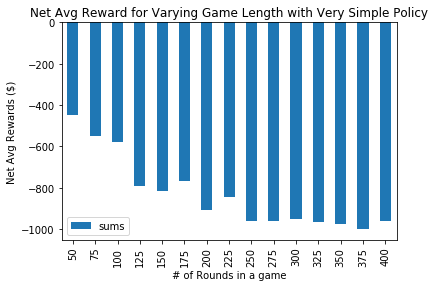

In [54]:
# Load rewards to a df
# x-axis will be # of rounds played
# y-axis will the avg rewards for playing 100 games with x # of rounds each.
df = pd.DataFrame(list(results.values()), columns = ["sums"], index = results.keys())

# sort by index align x/y axis properly
df.sort_index(inplace=True)

df.plot.bar()

plt.xlabel("# of Rounds in a game")
plt.ylabel("Net Avg Rewards ($)")
plt.title("Net Avg Reward for Varying Game Length with Very Simple Policy")

plt.show()

**Some Comments About this Approach**

I have realized that this approach of making # of rounds the x-axis will not yield much useful intelligence. This approach is not really showing me the average value of this approach in any given round. Even if I were to use a policy much more optimized than Very Simple Policy with, for example, only a 0.5% edge to the casino/dealer, the graph would still look like the graph above in the long run.

This is because this tiny edge for the casino/dealer in any given round will compound as the game has more and more rounds.

So, I will be simulating this differently below to get some insight into the average gain/loss per round using Very Simple Policy

## Run many, many games with just 1 round in each to approximate average gain/loss per round.

**Run Simulations.**

In [23]:
results = {}

num_rds = 1
num_games = 10000

net_avg = 0

for i in range(num_games):
    net_avg += play_game(very_simple_policy, num_rounds = num_rds)
net_avg /= num_games

results[num_games] = net_avg

**Graph the results.**

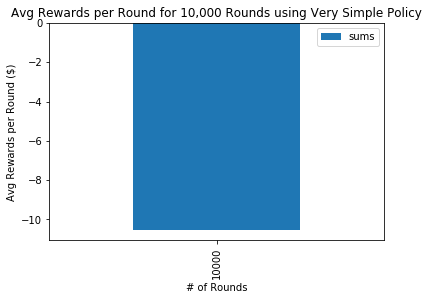

In [24]:
# Load rewards to a df
# x-axis will be # of games played. Not really an x-axis b/c there is just one value
# y-axis will the avg gains/losses for any given round using Very Simple Policy
df = pd.DataFrame(list(results.values()), columns = ["sums"], index = results.keys())

# sort by index align x/y axis properly
df.sort_index(inplace=True)

df.plot.bar()

plt.xlabel("# of Rounds")
plt.ylabel("Avg Rewards per Round ($)")
plt.title("Avg Rewards per Round for 10,000 Rounds using Very Simple Policy")

plt.show()

# Simulate Simple Policy + Graph Results

Simple Policy:  
If hand >= 18: 80% player stands, 20% player hits  
Else: 80% player hits, 20% player stands.

**Implement Simple Policy by defining what player should do on their turn.**

In [55]:
def simple_policy(player_hand, deck):
    player_value = player_eval(player_hand)
    
    # Implement Simple Policy
    # If hand >= 18: 80% Stand, 20% Hit
    # Else: 80% Hit, 20% Stand
    
    stand = False
    while player_value < 18 and stand == False:
        percent = random.randint(1, 10)
        if percent <= 8:
            # hit
            player_hand.append(deck.deal())
            player_value = player_eval(player_hand)
        else:
            # stand
            stand = True
    
    if stand:
        return player_value, player_hand, deck
    
    # player_value is now >= 18.
    if player_value < 21:
        percent = random.randint(1, 10)
        if percent > 8:
            # hit
            player_hand.append(deck.deal())
            player_value = player_eval(player_hand)        
            
        # else: Do nothing, stand.
    # else: player_value is 21 or higher, so we must stand in both cases.
    
    return player_value, player_hand, deck

**Run Simulations.**

In [56]:
results = {}

for num_rds in range(50, 401, 25):
    # Play 100 games in this num_rounds, find avg
    net_avg = 0
    for i in range(100):
        net_avg += play_game(player_policy = simple_policy, num_rounds = num_rds)
    net_avg /= 100
    
    results[num_rds] = net_avg

**Graph the results.**

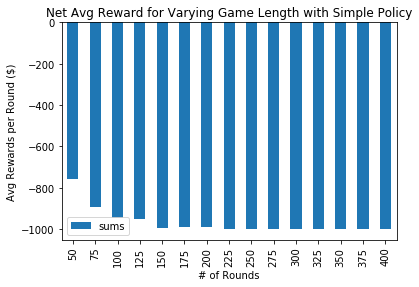

In [57]:
# Load rewards to a df
# x-axis will be # of rounds played
# y-axis will the avg rewards for playing 100 games with x # of rounds each.
df = pd.DataFrame(list(results.values()), columns = ["sums"], index = results.keys())

# sort by index align x/y axis properly
df.sort_index(inplace=True)

df.plot.bar()

plt.xlabel("# of Rounds")
plt.ylabel("Avg Rewards per Round ($)")
plt.title("Net Avg Reward for Varying Game Length with Simple Policy")

plt.show()

**Some Comments on this Approach**

Like I mentioned for the Very Simple Policy simulations, this is not a very efficient method for visualizing the approximate value of this particular policy.

The only thing that can be gained from this is that the Simple Policy dips towards very negative average rewards per game much quicker and steeper than Very Simple Policy.

However, I will still need to do the other simulation where I play many, many games with 1 round each to get the average gains/losses for any given round/hand of Blackjack

## Run many, many games with just 1 round in each to approximate average gain/loss per round.

**Run Simulations.**

In [60]:
results = {}

num_rds = 1
num_games = 10000

net_avg = 0

for i in range(num_games):
    net_avg += play_game(simple_policy, num_rounds = num_rds)
net_avg /= num_games

results[num_games] = net_avg

**Graph the results.**

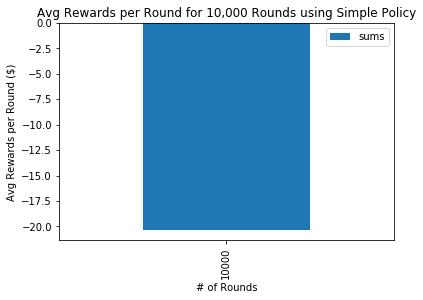

In [61]:
# Load rewards to a df
# x-axis will be # of games played. Not really an x-axis b/c there is just one value
# y-axis will the avg gains/losses for any given round using Very Simple Policy
df = pd.DataFrame(list(results.values()), columns = ["sums"], index = results.keys())

# sort by index align x/y axis properly
df.sort_index(inplace=True)

df.plot.bar()

plt.xlabel("# of Rounds")
plt.ylabel("Avg Rewards per Round ($)")
plt.title("Avg Rewards per Round for 10,000 Rounds using Simple Policy")

plt.show()

## Very Simple Policy vs Simple Policy

By comparing the charts for these two policies, we can hypothesize that the Very Simple Policy is a better approach to Blackjack than Simple Policy

The graph for the Simple Policy shows that as the # of rounds per game increase, the net average rewards decline at a faster rate than that of the Very Simple Policy. However, this is not a very reliable metric/visualization.

The second pair of graphs that determine average rewards per round are much more insightful. The average result for any given round of Blackjack using Very Simple Policy is about -\\$10. That value is about -\\$20 when using Simple Policy. Both strategies yield negative returns, meaning that a Blackjack player will only lose money in the long run by using either of these strategies.

-\\$10 rewards for Very Simple Policy means that the casino has an edge of about 10% when a player uses this strategy. This is because the max that a player can gain/lose in any given round in the current Blackjack environment is \\$100. So, -\\$10 rewards in the context of a max gain/loss of \\$100 is a 10% disadvantage. This means that Simple Policy yields a 20% disadvantage for the player. My goal is to employ Reinforcement Learning and Monte Carlo approaches to train my Blackjack agent to learn a policy that (hopefully) yields a positive edge for the player. Any % above 0% will suffice to guarantee net gains in the long run.

I believe this discrepancy between Very Simple Policy and Simple Policy is caused by the way the policies are defined. The Simple Policy is essentially a worse variation of the Very Simple Policy. The Simple Policy introduces a 20% chance to make an ill-advised decision in 2 binary states. These binary states are: the player's hand value is >= 18 and the player's hand value is < 18. 

Standing when hand value >= 18 and hitting when hand value < 18 seem to be reasonably safe ways to play Blackjack. This is how Very Simple Policy is defined. Although this policy is still very bad in a larger scope, it is understandable how Simple Policy makes Very Simple Policy even worse. Adding a 20% chance to hit when hand value >= 18 seems to open the strategy up to more unneccesary losses in the long run. The same is also true of adding a 20% chance to stand when hand value < 18.

For example, it is understandable to add the 20% chance to stand for hand values between 14-18. However, this 20% stand possibility also exists for all hand values below 14, which does not make much sense. Overall, the few advantages gained in the 14-18 hand value range do not outweigh the disastrous consequences on all hand values below 14.

## Simulate Using Edward O. Thorpe's Basic Strategy

We can expect to see a 0.44% edge for the casino, which is much better than Very Simple Policy.

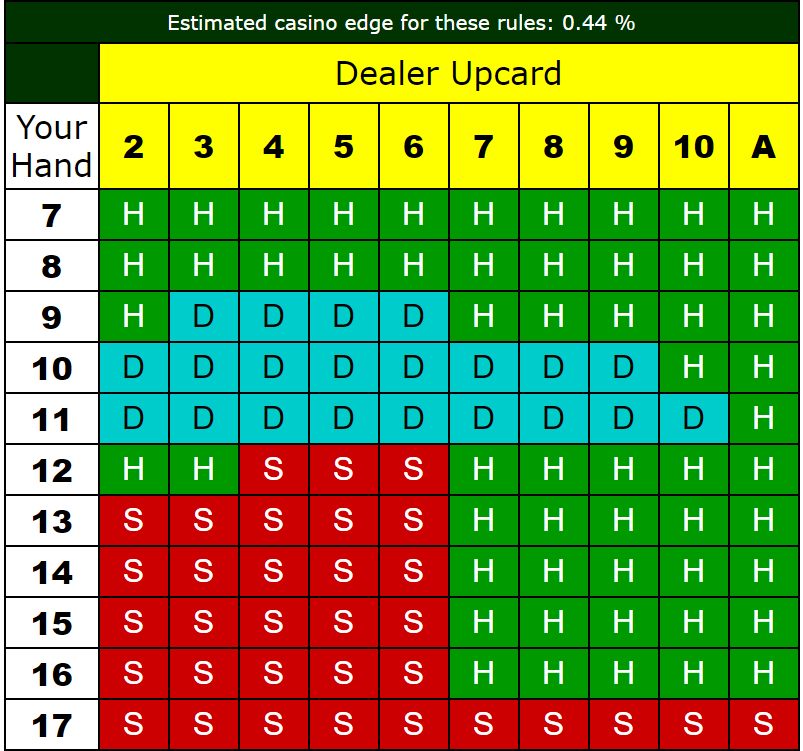

### Implement Edward Thorpe's Basic Strategy

In [43]:
# 0 -> stand
# 1 -> hit
ss_chart = {
    12 : [1,1,0,0,0,1,1,1,1,1],
    13 : [0,0,0,0,0,1,1,1,1,1],
    14 : [0,0,0,0,0,1,1,1,1,1],
    15 : [0,0,0,0,0,1,1,1,1,1],
    16 : [0,0,0,0,0,1,1,1,1,1]
}

def basic_strategy_policy(player_hand, dealer_upcard, deck):
    player_value = player_eval(player_hand)
    
    while player_value < 17:
        if player_value < 12: # Always hit if < 12
            # hit
            player_hand.append(deck.deal())
            player_value = player_eval(player_hand)
        else: # use ss_chart for >= 12 and < 17
            action = None
            if dealer_upcard.rank == "ace":
                action = ss_chart[player_value][-1]
            else:
                action = ss_chart[player_value][dealer_upcard.value - 2]
                
            if action == 0: # stand
                return player_value, player_hand, deck
            else: # action == 1, which is hit
                # hit
                player_hand.append(deck.deal())
                player_value = player_eval(player_hand)
        
    # Always stand if >= 17 and <= 21.
    return player_value, player_hand, deck

**Tweak play_game() to pass dealer_upcard into the player_policy.**

In [28]:
def play_game(player_policy, num_decks = 2, start_cash = 1000, num_rounds = 100):
    # Our Blackjack deck will be made of 2 normal decks by default.
    bj_deck = Deck(num_decks)

    # Shuffle before beginning. Only shuffle once before the start of each game.
    bj_deck.shuffle()
    
    # Keeps track of rewards/punishments. Also allows game to end before num_rounds.
    player_cash = start_cash
    
    rounds_played = 0
    
    while rounds_played < num_rounds and player_cash > 0:
        # Assume player bets 100 each round.
        # Gains 100 for winning round.
        # Loses 100 for losing round.
        # Nothing happens if tie. (Needs to change when actually training, so that agent tries to win more than tie.)
        
        player_hand = [bj_deck.deal(), bj_deck.deal()]
        dealer_hand = [bj_deck.deal(), bj_deck.deal()]
        
        dealer_upcard = dealer_hand[0]
        
        ## Begin player turn phase.
        
        player_value, player_hand, bj_deck = player_policy(player_hand, dealer_upcard, bj_deck)
            
        ## Player turn phase over.
        
        #--------------------------------------------------------#
        
        ## Begin automated phase of the Dealer's Play and
        ## determining the winner of the round.
        
        if player_value > 21: # above 21, player loses automatically.
            player_cash -= 100
        elif player_value == 21: # blackjack! Player wins automatically.
            player_cash += 100
        else:
            ## Begin dealer turn phase.
            
            dealer_value, dealer_hand, bj_deck = dealer_turn(dealer_hand, bj_deck)
                
            ## End of dealer turn phase
            
            #------------------------------------------------------------#
            
            ## Final Compare
            
            if dealer_value > 21: # dealer above 21, player wins automatically
                player_cash += 100
            elif dealer_value == 21: # dealer has blackjack, player loses automatically
                player_cash -= 100
            else: # dealer and player have values less than 21.
                if player_value > dealer_value: # player closer to 21, player wins.
                    player_cash += 100
                elif player_value < dealer_value: # dealer closer to 21, dealer wins.
                    player_cash -= 100
                # Nothing happens if a tie.
                
        ## End of round formalities
        
        # Add all cards to the end of deck, and shuffle. 
        # (Shuffling not usually done in casino blackjack.)
        bj_deck.cards += player_hand
        bj_deck.cards += dealer_hand
        bj_deck.shuffle()
            
        rounds_played += 1
        
    # Returns net gains/losses of playing
    return player_cash - start_cash

**Run Simple Simulations.**

Don't make x-axis # of rounds. Don't vary the number of rounds. The previous simulation shows that there aren't any reliable trends that can be observed by splitting it up by # of rounds.

Focus more on just repeatedly running a game with a high, set # of rounds to get towards a average reward.

Here, we opt for 10,000 games of 1 round each to see the average reward per round.

In [46]:
results = {}
num_rds = 1
num_games = 10000

for i in range(num_games):
    net_avg += play_game(basic_strategy_policy, num_rounds = num_rds)
net_avg /= num_games

results[num_games] = net_avg

**Graph the results.**

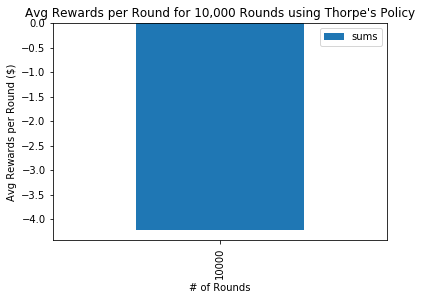

In [48]:
# Load rewards to a df
# x-axis will be # of games played. Not really an x-axis b/c there is just one value
# y-axis will the avg gains/losses for any given round using Thorpe's Basic Strategy Policy
df = pd.DataFrame(list(results.values()), columns = ["sums"], index = results.keys())

# sort by index align x/y axis properly
df.sort_index(inplace=True)

df.plot.bar()

plt.xlabel("# of Rounds")
plt.ylabel("Avg Rewards per Round ($)")
plt.title("Avg Rewards per Round for 10,000 Rounds using Thorpe's Policy")

plt.show()

### Analysis/Comments on Simulating Edward Thorpe's Basic Strategy

The chart above shows that this simulation did not yield the actual 0.44\\% casino edge that is expected of Edward Thorpe's Basic Strategy chart. Instead, my simulation yielded approximately a 4.5\\% casino edge. Although this simulation missed the expected 0.44\\%, this is still a vast improvement from my previous best policy (Very Simple Policy). 

This also motivates me to figure out where this simulation approach went wrong, and how I can improve to get closer to the goal of 0.44%. I think the main reason that my simulations are running sub-optimally is due to the numerous simplifications I made to my version of Blackjack compared to the real game. As a result, there are many nuances of Edward Thorpe's Basic Strategy that are left out. For example, I did not factor in any of Edward Thorpe's logic for playing with Aces in your hand. I just considered the Ace being treated as 1s or 11s and following the simplified chart logic for whatever the hand total happened to be. 

Additionally, I did not give the player the option to double their bet in my version of Blackjack. Edward Thorpe's Basic Strategy does instruct the player to double-down on their bet in particularly high-value positions. If my simulation were to account for this, I think there would more instances where my player gained a larger reward than they would have in my simplified model, which would have yielded a lower casino edge as a result.

Also, I did not explore any of the nuances regarding splitting your Blackjack hand when having a pair of the same rank.